# TORNADO TRACK PLOTTER TOOL
### A MODERN VISUALIZATION OF SPC TORNADO TRACKS DATA 
#### BY KYLE J GILLETT (@WXKYLEGILLETT) | (C) 2023
### ---------------------------------------------

##### > WROTE AND DEVELOPED BY KYLE J GILLETT
##### > SOURCE: SPC SVRGIS TORNADO TRACK DATABASE
##### > CURRENTLY, DATA IS AVAILABLE FROM 1950-2021. ONCE NEW DATA IS AVAILABLE THIS WILL NEED TO BE UPDATED
##### > POWERED BY CARTOPY, MATPLOTLIB, GEOPY AND METPY

##### > You can plot state sorted tracks, date sorted tracks, or both. At the bottom of this notebook, there is also an option to plot a full CONUS view of the entire 1950-2021 dataset. Several settings allow you to change the plot background type, zoom level, City/State to center the plot, and the date. You will also find settings to plot tracks that have enlarged widths (recommended for best viewing) or tracks with actual max-widths that are to-scale (cool, and more accurate, but as much as 90% of tornadoes wont show up on the plot because their max width is too small).

##### > DISCLAIMER: The data in this SPC dataset may be incomplete, missing, or incorrect on occasion. Its has been noted that some tracks are duplicated or missing, so counts of tornadoes may be slightly off. Additionally, it should be understood that these tracks are line-segments tracks, so the data consists of start and end lat/lon points - which means vital track information in between is missing and not provided in this data. The ratings of each tornado are described by the max rating. You can read this paper by Edwards et. al. 2021 for more details about this dataset: https://www.spc.noaa.gov/publications/edwards/f-ef.pdf

In [1]:
# IMPORTS -----------------------------------------------------------------------------------------------------------------------
import warnings                                                                  
warnings.filterwarnings("ignore")  

import cartopy.feature as cfeature
import cartopy.crs as ccrs
import pandas         as pd
import numpy          as np
import matplotlib
import matplotlib.pyplot   as plt
from metpy.plots import USCOUNTIES
import cartopy.feature as cfeature
import matplotlib.patheffects as pe
from geopy.geocoders  import Nominatim
import cartopy.io.img_tiles as cimgt
from datetime       import datetime, timedelta
from dateutil       import tz
import time
from timezonefinder import TimezoneFinder


states = {
    'AK': 'Alaska',
    'AL': 'Alabama',
    'AR': 'Arkansas',
    'AZ': 'Arizona',
    'CA': 'California',
    'CO': 'Colorado',
    'CT': 'Connecticut',
    'DC': 'District of Columbia',
    'DE': 'Delaware',
    'FL': 'Florida',
    'GA': 'Georgia',
    'HI': 'Hawaii',
    'IA': 'Iowa',
    'ID': 'Idaho',
    'IL': 'Illinois',
    'IN': 'Indiana',
    'KS': 'Kansas',
    'KY': 'Kentucky',
    'LA': 'Louisiana',
    'MA': 'Massachusetts',
    'MD': 'Maryland',
    'ME': 'Maine',
    'MI': 'Michigan',
    'MN': 'Minnesota',
    'MO': 'Missouri',
    'MS': 'Mississippi',
    'MT': 'Montana',
    'NC': 'North Carolina',
    'ND': 'North Dakota',
    'NE': 'Nebraska',
    'NH': 'New Hampshire',
    'NJ': 'New Jersey',
    'NM': 'New Mexico',
    'NV': 'Nevada',
    'NY': 'New York',
    'OH': 'Ohio',
    'OK': 'Oklahoma',
    'OR': 'Oregon',
    'PA': 'Pennsylvania',
    'RI': 'Rhode Island',
    'SC': 'South Carolina',
    'SD': 'South Dakota',
    'TN': 'Tennessee',
    'TX': 'Texas',
    'UT': 'Utah',
    'VA': 'Virginia',
    'VT': 'Vermont',
    'WA': 'Washington',
    'WI': 'Wisconsin',
    'WV': 'West Virginia',
    'WY': 'Wyoming'
}
print('-')

-


### USER DATA

In [2]:
yourName = 'YOUR NAME' # ADD YOUR NAME IN ALL CAPS TO THE BOTTOM OF THE PLOT

#### PLOT TYPE (all tornadoes for state, or all tornadoes on a date, or both)
plotType = 'state'
#plotType = 'date'
#plotType = 'state-date'

#### LOCATION (use 'city' to center the plot how you like, 'state' determines what state to plot. The city needs to be in the state you choose)
city     = "Colo"
stateAbv = "IA"

#### Date variables only needed if making a date plot **(UTC TIME)**
year     = "2008"
month    = "05"
day      = "25"

#### BACKGROUND STYLE
#background = 'gray' # Gray
background = 'terrain' # Detailed Terrain
#background = 'terrain-gray' # Dimmed Terrain 
#background = 'terrain-labels' # Terrain with physical and cultural lables (image overly quaility is so-so)

#### ZOOM LEVEL
#zoomLevel = 'regional'
#zoomLevel = 'sub-regional'
zoomLevel = 'state-large'
#zoomLevel = 'state-small'
#zoomLevel = 'sub-state'
#zoomLevel = 'local'

# determine lat/lon of user specified city for map center - this does not change
geolocator = Nominatim(user_agent="Your_Name") #do not change this line
loc = geolocator.geocode(city+','+ states[stateAbv])
center_lat = (np.round(loc.latitude,2))
center_lon = np.round(loc.longitude,2)
# YOU CAN SET MANUAL LAT/LON HERE IF YOU'D LIKE
#center_lat1 = 43.1 
#center_lon1 = -83.73
# LAT / LON DETERMINED BY SELECTED CITY ABOVE 
center_lat1 = center_lat
center_lon1 = center_lon
# CREATE SMALL GRIDDED AREA FOR MAP
north_lat = center_lat1 + .5
south_lat = center_lat1 - .5
west_lon = center_lon1 - .5
east_lon = center_lon1 + .5

# DETERMINE ZOOM DETAILS FOR SELECTED zoomLevel ABOVE 
zooms = {
    'regional'       : [([west_lon -7, east_lon +7, south_lat -7, north_lat +7]), 7, 7],
    'sub-regional'   : [([west_lon -4.5, east_lon +4.5, south_lat -4.5, north_lat +4.5]), 7, 7],
    'state-large'    : [([west_lon -2.8, east_lon +2.8, south_lat -2.8, north_lat +2.8]), 10, 8],
    'state-small'    : [([west_lon -2.5, east_lon +2.5, south_lat -2.5, north_lat +2.5]), 10, 8],
    'sub-state'      : [([west_lon -1, east_lon +1, south_lat -1, north_lat +1]), 9, 9],
    'local'          : [([west_lon, east_lon, south_lat, north_lat]), 10, 10]
}

# DETERMINE LOCAL TIME TO CALCULATE OO UTC TO LOCAL MIDNIGHT OFFSET
# THIS WILL BE USED IN THE CELL BELOW FOR DATE SORTED TRACKS TO ACCOUNT 
# FOR TORNADOES BETWEEN 00Z UTC AND MIDNIGHT LOCAL TIME, THAT WAY THE PLOT IS 
# IN LOCAL TIME.
tzFinder = TimezoneFinder()                # create tz object to find tz automatically 
timeZone = tzFinder.timezone_at(lng=center_lon, lat=center_lat) # find tz for lat/lon
date1_dt = datetime(int(year), int(month), int(day), int(0)) # declare utc datetime object
from_zone = tz.gettz('UTC')                # 'from'-time zone (always UTC)
to_zone = tz.gettz(timeZone)               # 'to'-time zone
utc = date1_dt.replace(tzinfo=from_zone)   # tell UTC datetime object that it is in UTC time
local_date = utc.astimezone(to_zone)       # convert UTC datetime object to local datetime object
local_hour = local_date.strftime("%H")     # determine local hour in 24hr format

### FETCH AND PARSE SPC TORNADO TRACK DATA

In [6]:
# GRAB TORNADO TRACK DATA FROM SPC DATABASE ##################################################################################
tracks_df = pd.read_csv("https://www.spc.noaa.gov/wcm/data/1950-2021_actual_tornadoes.csv") #CSV TOR DATA

if plotType == 'state':
    date1_string = '1950-2021'
    title_string = f'{str.upper(states[stateAbv])} TORNADO TRACKS'
    track_data = tracks_df[tracks_df['st']==stateAbv] # PARSE DATA FOR DECLARED STATE 

if plotType == 'date':
    title_string = 'TORNADO TRACKS'
    date1_string = str(year +'-'+month+'-'+day)
    timeOffset = 24 - int(local_hour)
    date1_dt = datetime(int(year), int(month), int(day), int(0))
    date2_dt = date1_dt + timedelta(hours=24+timeOffset)
    date2_string = str(date2_dt.strftime("%Y") + '-' + date2_dt.strftime("%m") + '-' + date2_dt.strftime("%d"))
    print(f'DT1: {date1_dt},  DT2: {date2_dt}')
    D1 = tracks_df[tracks_df['date']==date1_string] # PARSE DATA FOR DATE 1
    D1 = D1[D1['time']>str(date2_dt.strftime("%H:%M:%S"))]
    D2 = tracks_df[tracks_df['date']==date2_string] # PARSE DATA FOR DATE 2 (UTC TIME after 00z)
    D2 = D2[D2['time']<=str(date2_dt.strftime("%H:%M:%S"))]
    frames = [D1, D2]
    track_data = pd.concat(frames) #PARSE DATA FOR DECALRED DATE

if plotType == 'state-date':
    title_string = f'{str.upper(states[stateAbv])} TORNADO TRACKS'
    date1_string = str(year +'-'+month+'-'+day)
    timeOffset = 24 - int(local_hour)
    date1_dt = datetime(int(year), int(month), int(day), int(0))
    date2_dt = date1_dt + timedelta(hours=24+timeOffset)
    date2_string = str(date2_dt.strftime("%Y") + '-' + date2_dt.strftime("%m") + '-' + date2_dt.strftime("%d"))
    print(f'DT1: {date1_dt},  DT2: {date2_dt}')
    D1 = tracks_df[tracks_df['date']==date1_string] # PARSE DATA FOR DATE 1
    D1 = D1[D1['time']>str(date2_dt.strftime("%H:%M:%S"))]
    D2 = tracks_df[tracks_df['date']==date2_string] # PARSE DATA FOR DATE 2 (UTC TIME after 00z)
    D2 = D2[D2['time']<=str(date2_dt.strftime("%H:%M:%S"))]
    frames = [D1, D2]
    track_data = pd.concat(frames) #PARSE DATA FOR DECALRED DATE
    track_data = track_data[track_data['st']==stateAbv] # PARSE DATA FOR DECLARED STATE 
    

# CORRECT TRACK LAT/LON POINT ERRORS (some end lat/lons are = zero, or equal to the start lat/lon
# because the path is around or less than 1 mile, so to simplifiy plotting, end lat/lons are set = to start lat/lons 
# plus 0.001 degrees of lat/lon)
track_data['elon'] = np.where(track_data['elon'] == 0, track_data['slon']+0.005, track_data['elon'])
track_data['elat'] = np.where(track_data['elat'] == 0, track_data['slat']+0.005, track_data['elat'])
track_data['elon'] = np.where(track_data['elon'] == track_data['slon'], track_data['slon']+0.005, track_data['elon'])
track_data['elat'] = np.where(track_data['elat'] == track_data['slat'], track_data['slat']+0.005, track_data['elat'])

# PARSE RATING MAGNITUDE INFORMATION
efu = track_data[track_data['fc']==1] 
ef0 = track_data[track_data['mag']==0] 
ef1 = track_data[track_data['mag']==1] 
ef2 = track_data[track_data['mag']==2] 
ef3 = track_data[track_data['mag']==3] 
ef4 = track_data[track_data['mag']==4] 
ef5 = track_data[track_data['mag']==5] 

# PARSE OUT SOME INFO ABOUT THE TORNADOES
total_path = int(track_data['len'].sum())
total_inj = track_data['inj'].sum()
total_fat = track_data['fat'].sum()

print(f'TORNADOES IN DATASET: {len(track_data)}')

TORNADOES IN DATASET: 2773


## MEDIUM-RESOLUTION MAP
#### PLOTS THE FASTEST BUT MAY APPEAR FUZZY IF THE IMAGE IS ZOOMED

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


YOU ARE PLOTTING: A "state" PLOT 
PLOT DATE: "1950-2021"
CENTER LOCATION: "Colo, IA"
ZOOM LEVEL: "state-large"
BACKGROUND STYLE: "terrain"


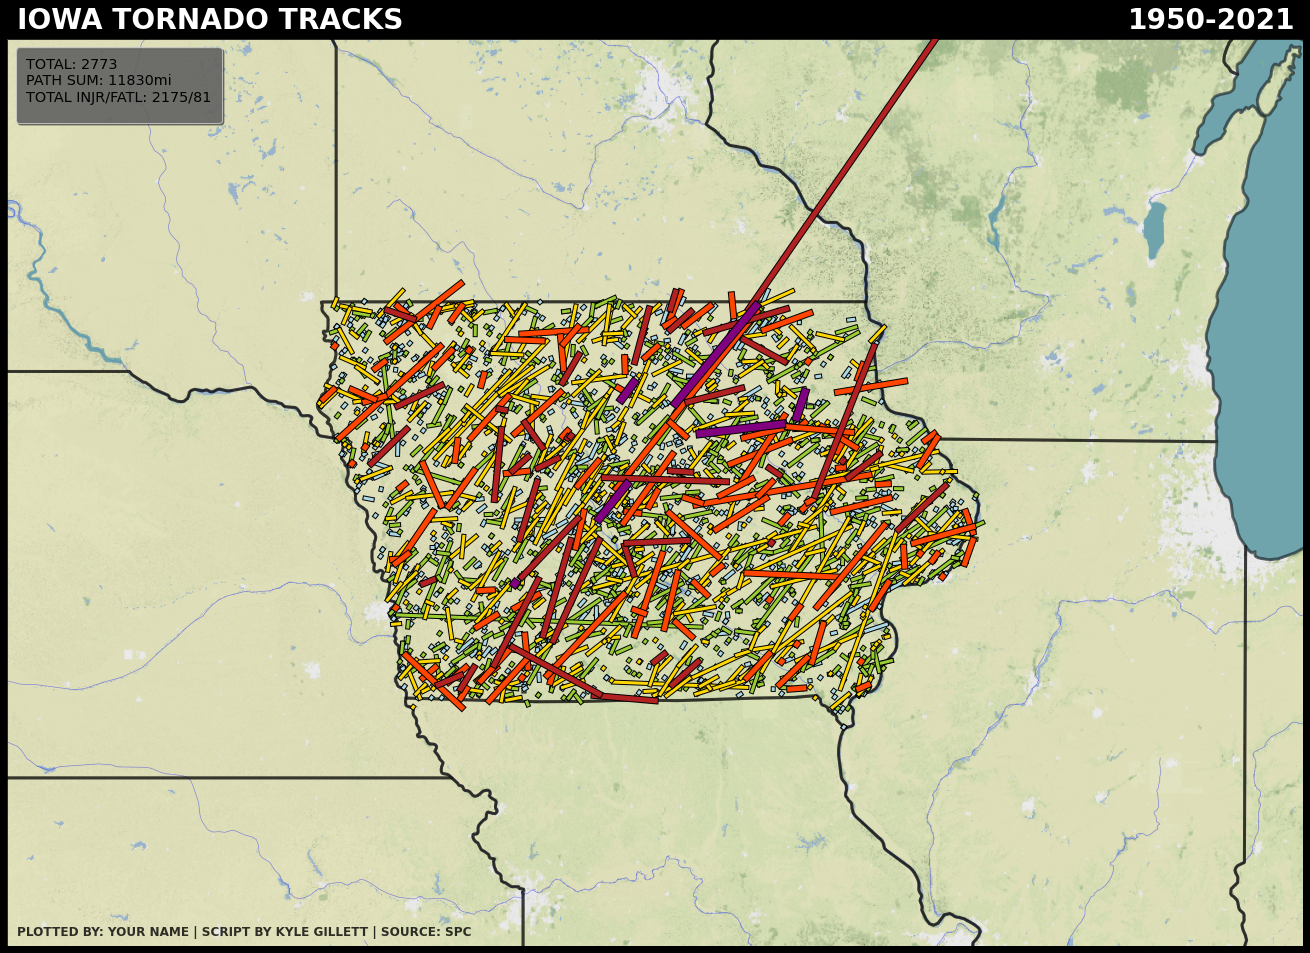

In [7]:
# CREATE FIGURE PROPERTIES ############################################################################################################
plt.figure(facecolor='black') 
proj = ccrs.Mercator(central_longitude=center_lat1, min_latitude=south_lat-5, max_latitude=north_lat+5)
ax = plt.axes((0.877, -0.26, 3, 5), projection=proj) 
ax.set_box_aspect(0.7) 


# DETERMINE ZOOM LEVEL ############################################################################################################
ax.set_extent(zooms[zoomLevel][0], ccrs.Geodetic())


# ADD MAP FEATURES ###################################################################################################################
ax.add_feature(cfeature.LAKES.with_scale('10m'), color='cadetblue', alpha=0.7, linewidth=0.5, zorder=2)
ax.add_feature(cfeature.RIVERS.with_scale('10m'), alpha=0.4, linewidth=0.7, color='blue')
ax.add_feature(cfeature.OCEAN.with_scale('10m'), color='gray', alpha=0.8, zorder=2)
ax.add_feature(USCOUNTIES.with_scale('500k'), alpha=0.4, edgecolor='gray', zorder=0)
ax.add_feature(cfeature.STATES.with_scale('10m'), edgecolor='black', alpha=0.5, linewidth=3, zorder=3)
ax.add_feature(cfeature.LAND.with_scale('10m'), color='dimgray', alpha=1)


#BACKGROUND
if background == 'terrain':    
    stamen_terrain = cimgt.Stamen('terrain-background')
    ax.add_feature(cfeature.LAND.with_scale('10m'), color='black', alpha=1)
    ax.add_image(stamen_terrain, zooms[zoomLevel][1], alpha=1)
elif background == 'terrain-gray':    
    stamen_terrain = cimgt.Stamen('terrain-background')
    ax.add_image(stamen_terrain, zooms[zoomLevel][1], alpha=0.4)
elif background == 'terrain-labels':    
    stamen_terrain = cimgt.Stamen('terrain')
    ax.add_image(stamen_terrain, zooms[zoomLevel][1], alpha=0.8, zorder=4)
    

# PLOT TORNADO TRACKS ###############################################################################################################
ax.plot([efu['slon'], efu['elon']], [efu['slat'], efu['elat']], color='lightcyan', linewidth=3, transform=ccrs.PlateCarree(), path_effects=[pe.Stroke(linewidth=5, foreground='black'), pe.Normal()], zorder=5)
ax.plot([ef0['slon'], ef0['elon']], [ef0['slat'], ef0['elat']], color='lightblue', linewidth=3, transform=ccrs.PlateCarree(), path_effects=[pe.Stroke(linewidth=5, foreground='black'), pe.Normal()], zorder=5)
ax.plot([ef1['slon'], ef1['elon']], [ef1['slat'], ef1['elat']], color='yellowgreen', linewidth=3, transform=ccrs.PlateCarree(), path_effects=[pe.Stroke(linewidth=5, foreground='black'), pe.Normal()], zorder=5)
ax.plot([ef2['slon'], ef2['elon']], [ef2['slat'], ef2['elat']], color='gold', linewidth=3, transform=ccrs.PlateCarree(), path_effects=[pe.Stroke(linewidth=5, foreground='black'), pe.Normal()], zorder=5)
ax.plot([ef3['slon'], ef3['elon']], [ef3['slat'], ef3['elat']], color='orangered', linewidth=5, transform=ccrs.PlateCarree(), path_effects=[pe.Stroke(linewidth=7, foreground='black'), pe.Normal()], zorder=5)
ax.plot([ef4['slon'], ef4['elon']], [ef4['slat'], ef4['elat']], color='firebrick', linewidth=5, transform=ccrs.PlateCarree(), path_effects=[pe.Stroke(linewidth=7, foreground='black'), pe.Normal()], zorder=5)
ax.plot([ef5['slon'], ef5['elon']], [ef5['slat'], ef5['elat']], color='purple', linewidth=7, transform=ccrs.PlateCarree(), path_effects=[pe.Stroke(linewidth=9, foreground='black'), pe.Normal()], zorder=5)

# #dummy data to make the legend clean
# ax.plot(-100, 100, color='purple', linewidth=7, transform=ccrs.PlateCarree(), path_effects=[pe.Stroke(linewidth=9, foreground='black'), pe.Normal()], label = f'(E)F5: {len(ef5)}')
# ax.plot(-100, 100, color='firebrick', linewidth=7, transform=ccrs.PlateCarree(), path_effects=[pe.Stroke(linewidth=9, foreground='black'), pe.Normal()], label = f'(E)F4: {len(ef4)}')
# ax.plot(-100, 100, color='orangered', linewidth=7, transform=ccrs.PlateCarree(), path_effects=[pe.Stroke(linewidth=9, foreground='black'), pe.Normal()], label = f'(E)F3: {len(ef3)}')
# ax.plot(-100, 100, color='gold', linewidth=7, transform=ccrs.PlateCarree(), path_effects=[pe.Stroke(linewidth=9, foreground='black'), pe.Normal()], label = f'(E)F2: {len(ef2)}')
# ax.plot(-100, 100, color='yellowgreen', linewidth=7, transform=ccrs.PlateCarree(), path_effects=[pe.Stroke(linewidth=9, foreground='black'), pe.Normal()], label = f'(E)F1: {len(ef1)}')
# ax.plot(-100, 100, color='lightblue', linewidth=7, transform=ccrs.PlateCarree(), path_effects=[pe.Stroke(linewidth=9, foreground='black'), pe.Normal()], label = f'(E)F0: {len(ef0)}')
# ax.plot(-100, 100, color='lightcyan', linewidth=7, transform=ccrs.PlateCarree(), path_effects=[pe.Stroke(linewidth=9, foreground='black'), pe.Normal()], label = f'(E)FU: {len(efu)}')

# PLOT TITLES AND DATA #####################################################################################################################
# create a custom title or leave it to automation
#title_string = 'April 27th, 2011 Super Outbreak Tornado Tracks'
plt.figtext(0.90, 3.85, f'{title_string}', weight='bold', fontsize=28, ha='left', color='white')
plt.figtext(3.86, 3.85, f'{date1_string}', weight='bold', fontsize=28, ha='right', color='white')
plt.figtext(0.90, 0.7, f'PLOTTED BY: {yourName} | SCRIPT BY KYLE GILLETT | SOURCE: SPC', weight='bold', color='black', fontsize=12, ha='left', alpha=0.8)
ax.legend(loc='upper left', framealpha=0.8, fontsize='xx-large', facecolor='dimgray', labelcolor='linecolor', shadow=True, borderpad=0.6, title=f'TOTAL: {len(track_data)}\nPATH SUM: {total_path}mi\nTOTAL INJR/FATL: {total_inj}/{total_fat}', title_fontsize='x-large').set_zorder(10)

print(f'YOU ARE PLOTTING: A "{plotType}" PLOT \nPLOT DATE: "{date1_string}"\nCENTER LOCATION: "{city}, {stateAbv}"\nZOOM LEVEL: "{zoomLevel}"\nBACKGROUND STYLE: "{background}"')



## HIGH-RESOLUTION MAP
#### WILL TAKE A LITTLE LONGER TO LOAD BUT WILL PRODUCE A NICER PLOT

YOU ARE PLOTTING: A "date" PLOT 
PLOT DATE: "2008-05-25"
CENTER LOCATION: "Colo, IA"
ZOOM LEVEL: "state-large"
BACKGROUND STYLE: "terrain"


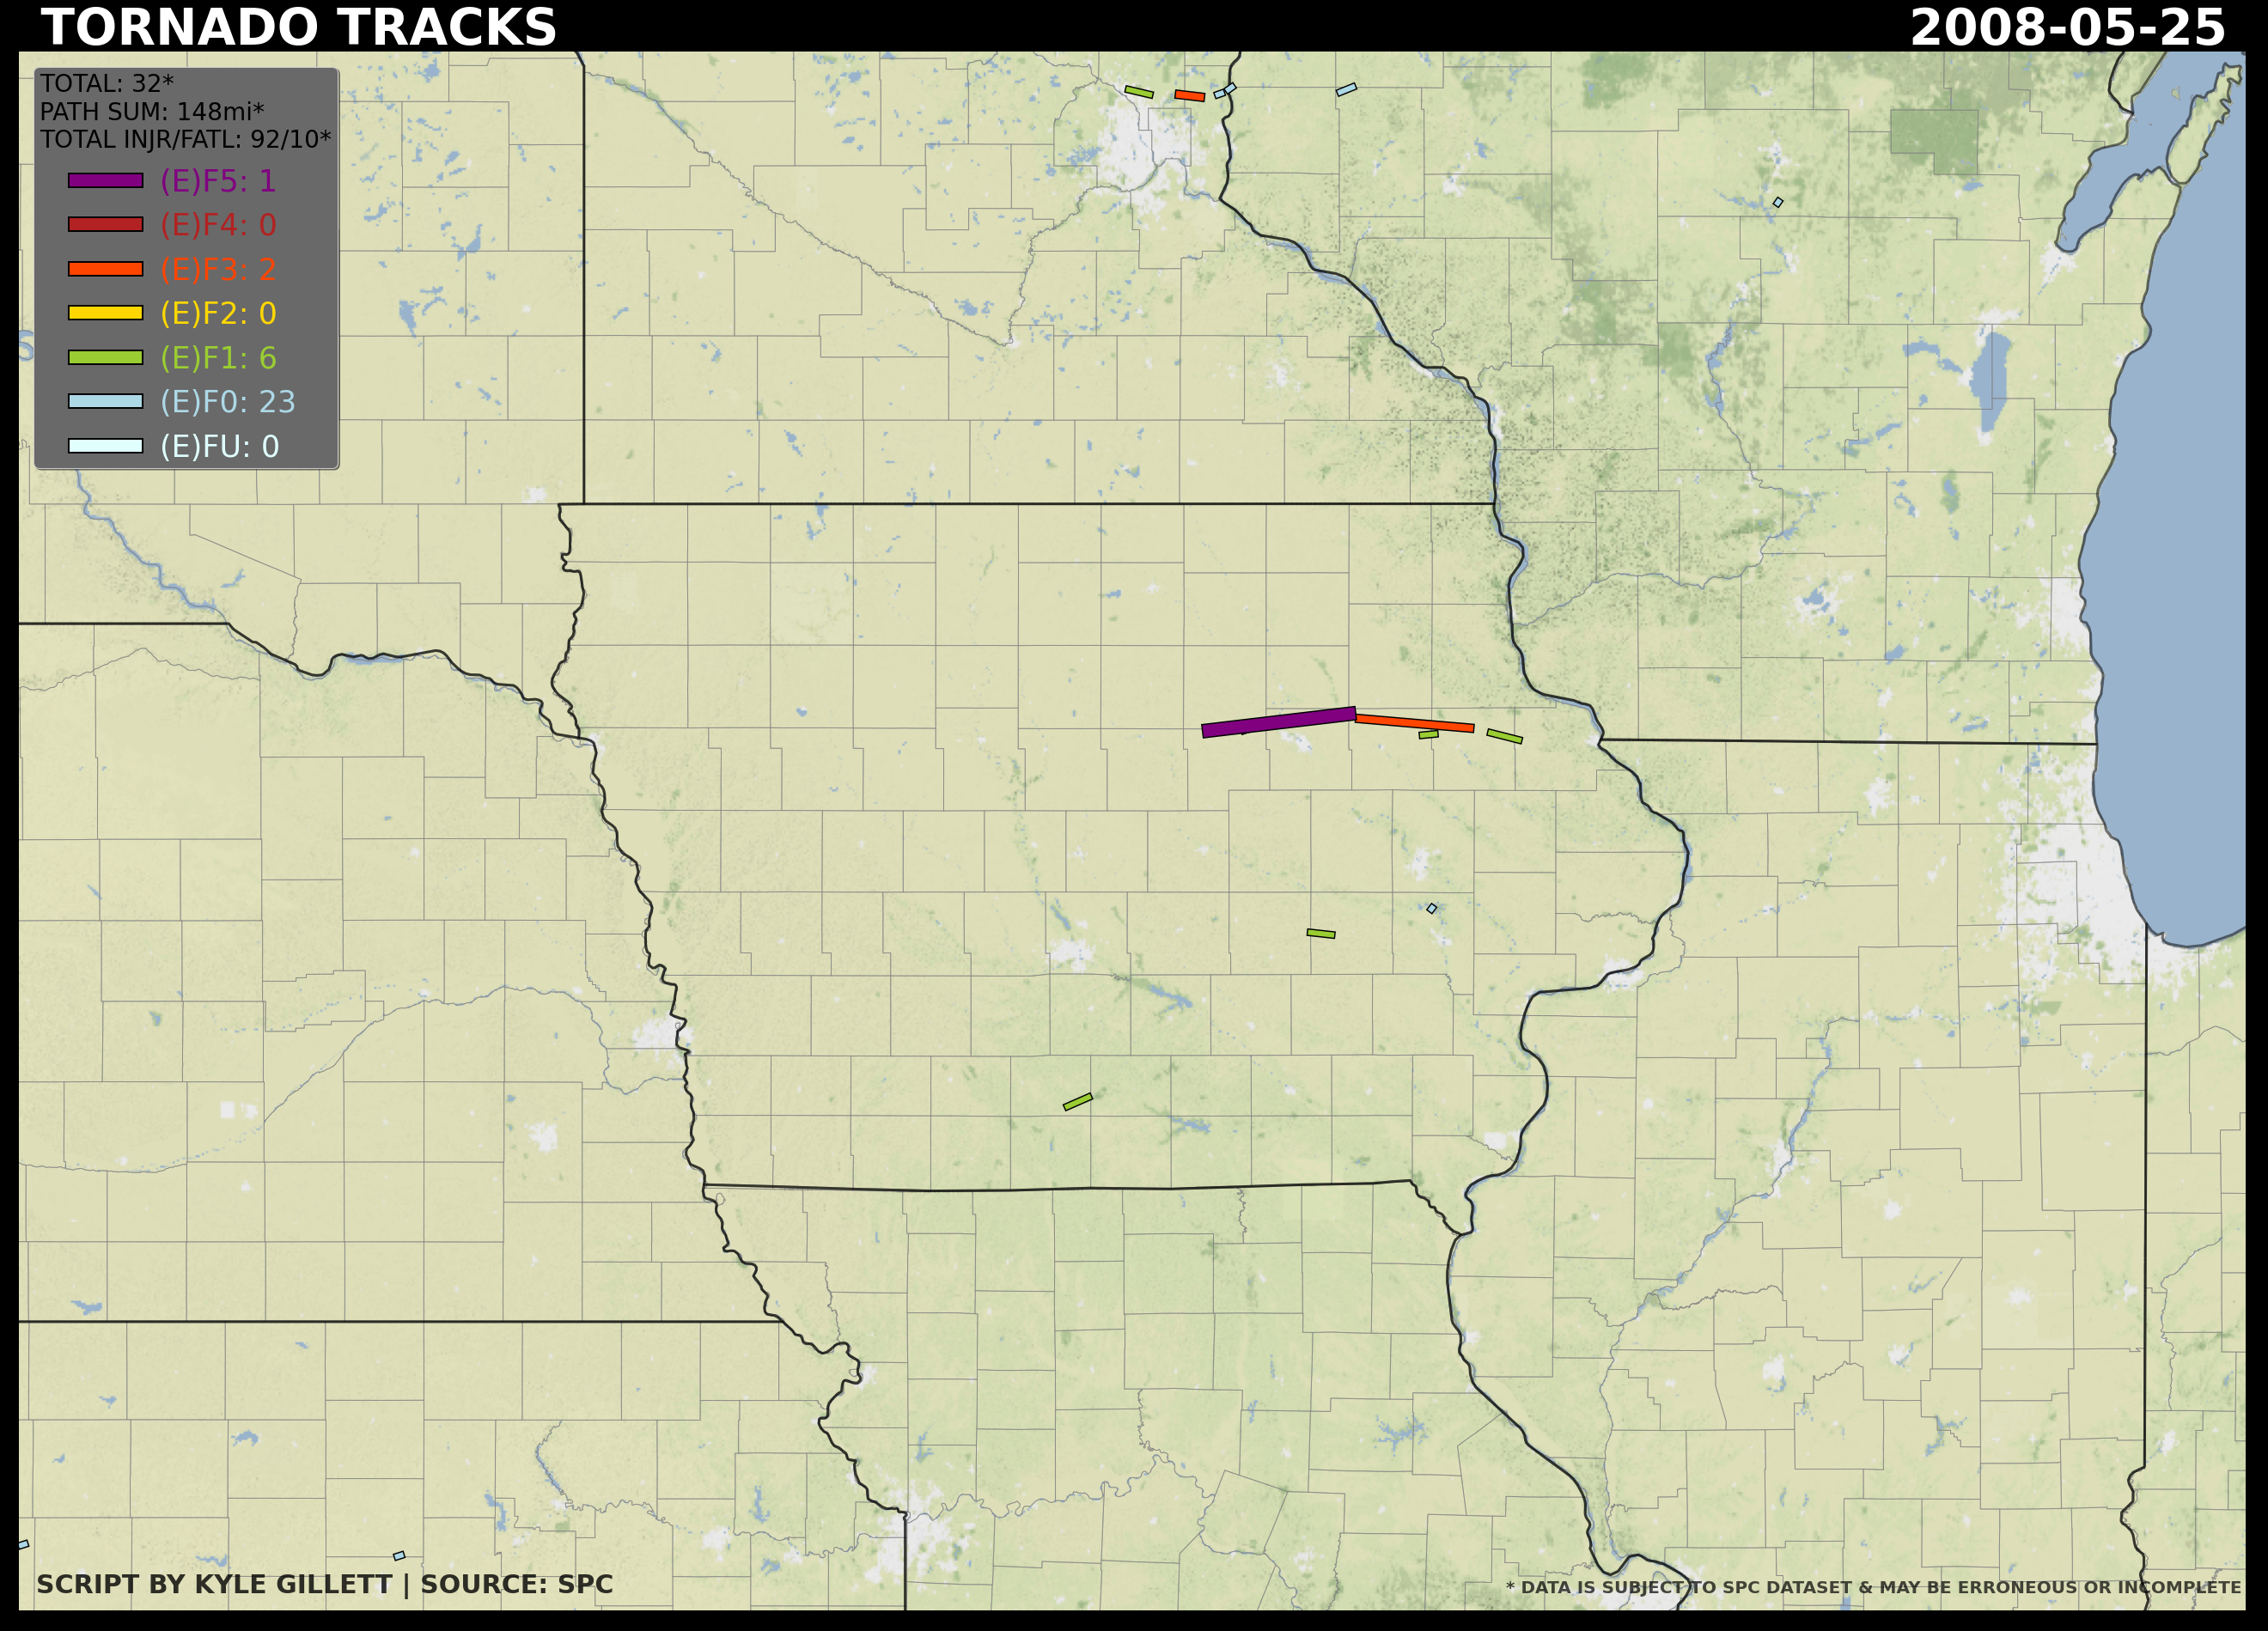

In [22]:
# CREATE FIGURE PROPERTIES ############################################################################################################
plt.figure(facecolor='black', figsize=(12,7)) 
proj = ccrs.Mercator(central_longitude=center_lat1, min_latitude=south_lat-5, max_latitude=north_lat+5)
ax = plt.axes((0.877, -0.26, 3, 5), projection=proj) 
ax.set_box_aspect(0.7) 


# DETERMINE ZOOM LEVEL ############################################################################################################
ax.set_extent(zooms[zoomLevel][0], ccrs.Geodetic())


# ADD MAP FEATURES ###################################################################################################################
ax.add_feature(cfeature.LAKES.with_scale('10m'), color='cadetblue', alpha=0.7, linewidth=0.5, zorder=2)
ax.add_feature(cfeature.RIVERS.with_scale('10m'), alpha=0.4, linewidth=0.7, color='blue')
ax.add_feature(cfeature.OCEAN.with_scale('10m'), color='gray', alpha=0.8, zorder=3)
ax.add_feature(USCOUNTIES.with_scale('500k'), alpha=0.6, edgecolor='gray', zorder=4)
ax.add_feature(cfeature.STATES.with_scale('10m'), edgecolor='black', alpha=0.5, linewidth=3, zorder=5)
ax.add_feature(cfeature.LAND.with_scale('10m'), color='dimgray', alpha=1)


#BACKGROUND
if background == 'terrain':    
    stamen_terrain = cimgt.Stamen('terrain-background')
    ax.add_feature(cfeature.LAND.with_scale('10m'), color='black', alpha=1)
    ax.add_image(stamen_terrain, zooms[zoomLevel][1], alpha=1, zorder=3)
elif background == 'terrain-gray':    
    stamen_terrain = cimgt.Stamen('terrain-background')
    ax.add_image(stamen_terrain, zooms[zoomLevel][1], alpha=0.4, zorder=3)
elif background == 'terrain-labels':    
    stamen_terrain = cimgt.Stamen('terrain')
    ax.add_image(stamen_terrain, zooms[zoomLevel][1], alpha=0.8, zorder=4)

    
# # PLOT TORNADO TRACKS TO SCALE ###############################################################################################################
# for i in efu.index:
#     ax.plot([efu['slon'][i], efu['elon'][i]], [efu['slat'][i], efu['elat'][i]], color='black', linewidth=(efu['wid'][i])/3456, transform=ccrs.PlateCarree(), zorder=6)
# for i in ef0.index:
#     ax.plot([ef0['slon'][i], ef0['elon'][i]], [ef0['slat'][i], ef0['elat'][i]], color='black', linewidth=(ef0['wid'][i])/3456, transform=ccrs.PlateCarree(), zorder=6)
# for i in ef1.index:
#     ax.plot([ef1['slon'][i], ef1['elon'][i]], [ef1['slat'][i], ef1['elat'][i]], color='black', linewidth=(ef1['wid'][i])/3456, transform=ccrs.PlateCarree(), zorder=6)
# for i in ef2.index:
#     ax.plot([ef2['slon'][i], ef2['elon'][i]], [ef2['slat'][i], ef2['elat'][i]], color='black', linewidth=(ef2['wid'][i])/3456, transform=ccrs.PlateCarree(), zorder=6)
# for i in ef3.index:
#     ax.plot([ef3['slon'][i], ef3['elon'][i]], [ef3['slat'][i], ef3['elat'][i]], color='black', linewidth=(ef3['wid'][i])/3456, transform=ccrs.PlateCarree(), zorder=6)
# for i in ef4.index:
#     ax.plot([ef4['slon'][i], ef4['elon'][i]], [ef4['slat'][i], ef4['elat'][i]], color='black', linewidth=(ef4['wid'][i])/3456, transform=ccrs.PlateCarree(), zorder=6)
# for i in ef5.index:
#     ax.plot([ef5['slon'][i], ef5['elon'][i]], [ef5['slat'][i], ef5['elat'][i]], color='black', linewidth=(ef5['wid'][i])/3456, transform=ccrs.PlateCarree(), zorder=6)
    
# PLOT TORNADO TRACKS ###############################################################################################################
ax.plot([efu['slon'], efu['elon']], [efu['slat'], efu['elat']], color='lightcyan', linewidth=6, transform=ccrs.PlateCarree(), path_effects=[pe.Stroke(linewidth=9, foreground='black'), pe.Normal()], zorder=6)
ax.plot([ef0['slon'], ef0['elon']], [ef0['slat'], ef0['elat']], color='lightblue', linewidth=6, transform=ccrs.PlateCarree(), path_effects=[pe.Stroke(linewidth=9, foreground='black'), pe.Normal()], zorder=6)
ax.plot([ef1['slon'], ef1['elon']], [ef1['slat'], ef1['elat']], color='yellowgreen', linewidth=6, transform=ccrs.PlateCarree(), path_effects=[pe.Stroke(linewidth=9, foreground='black'), pe.Normal()], zorder=6)
ax.plot([ef2['slon'], ef2['elon']], [ef2['slat'], ef2['elat']], color='gold', linewidth=7, transform=ccrs.PlateCarree(), path_effects=[pe.Stroke(linewidth=10, foreground='black'), pe.Normal()], zorder=6)
ax.plot([ef3['slon'], ef3['elon']], [ef3['slat'], ef3['elat']], color='orangered', linewidth=8, transform=ccrs.PlateCarree(), path_effects=[pe.Stroke(linewidth=11, foreground='black'), pe.Normal()], zorder=6)
ax.plot([ef4['slon'], ef4['elon']], [ef4['slat'], ef4['elat']], color='firebrick', linewidth=11, transform=ccrs.PlateCarree(), path_effects=[pe.Stroke(linewidth=14, foreground='black'), pe.Normal()], zorder=6)
ax.plot([ef5['slon'], ef5['elon']], [ef5['slat'], ef5['elat']], color='purple', linewidth=14, transform=ccrs.PlateCarree(), path_effects=[pe.Stroke(linewidth=17, foreground='black'), pe.Normal()], zorder=6)

#dummy data to make the legend clean
ax.plot(-100, 100, color='purple', linewidth=14, transform=ccrs.PlateCarree(), path_effects=[pe.Stroke(linewidth=18, foreground='black'), pe.Normal()], label = f'(E)F5: {len(ef5)}')
ax.plot(-100, 100, color='firebrick', linewidth=14, transform=ccrs.PlateCarree(), path_effects=[pe.Stroke(linewidth=18, foreground='black'), pe.Normal()], label = f'(E)F4: {len(ef4)}')
ax.plot(-100, 100, color='orangered', linewidth=14, transform=ccrs.PlateCarree(), path_effects=[pe.Stroke(linewidth=18, foreground='black'), pe.Normal()], label = f'(E)F3: {len(ef3)}')
ax.plot(-100, 100, color='gold', linewidth=14, transform=ccrs.PlateCarree(), path_effects=[pe.Stroke(linewidth=18, foreground='black'), pe.Normal()], label = f'(E)F2: {len(ef2)}')
ax.plot(-100, 100, color='yellowgreen', linewidth=14, transform=ccrs.PlateCarree(), path_effects=[pe.Stroke(linewidth=18, foreground='black'), pe.Normal()], label = f'(E)F1: {len(ef1)}')
ax.plot(-100, 100, color='lightblue', linewidth=14, transform=ccrs.PlateCarree(), path_effects=[pe.Stroke(linewidth=18, foreground='black'), pe.Normal()], label = f'(E)F0: {len(ef0)}')
ax.plot(-100, 100, color='lightcyan', linewidth=14, transform=ccrs.PlateCarree(), path_effects=[pe.Stroke(linewidth=18, foreground='black'), pe.Normal()], label = f'(E)FU: {len(efu)}')

# PLOT TITLES AND DATA #####################################################################################################################
# create a custom title or leave it to automation
#title_string = 'April 27th, 2011 Super Outbreak Tornado Tracks'
plt.figtext(0.86, 4.057, f'  {title_string}', weight='bold', fontsize=58, ha='left', color='white')
plt.figtext(3.90, 4.057, f'{date1_string}  ', weight='bold', fontsize=58, ha='right', color='white')
plt.figtext(0.90, 0.48, f'SCRIPT BY KYLE GILLETT | SOURCE: SPC', weight='bold', color='black', fontsize=30, ha='left', alpha=0.8)
plt.figtext(3.88, 0.48, f'* DATA IS SUBJECT TO SPC DATASET & MAY BE ERRONEOUS OR INCOMPLETE ', weight='bold', color='black', fontsize=20, ha='right', alpha=0.7)
plt.figtext(0.90, 0.41, f' ')
ax.legend(loc='upper left', fontsize=35, facecolor='dimgray', markerscale=10, framealpha=1, labelcolor='linecolor', shadow=True, borderpad=0.2, title=f'TOTAL: {len(track_data)}*\nPATH SUM: {total_path}mi*\nTOTAL INJR/FATL: {total_inj}/{total_fat}*', title_fontsize=28).set_zorder(10)


print(f'YOU ARE PLOTTING: A "{plotType}" PLOT \nPLOT DATE: "{date1_string}"\nCENTER LOCATION: "{city}, {stateAbv}"\nZOOM LEVEL: "{zoomLevel}"\nBACKGROUND STYLE: "{background}"')



### PLOT ALL TORNADOES - US ZOOM

TORNADOES IN DATASET: 67558


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


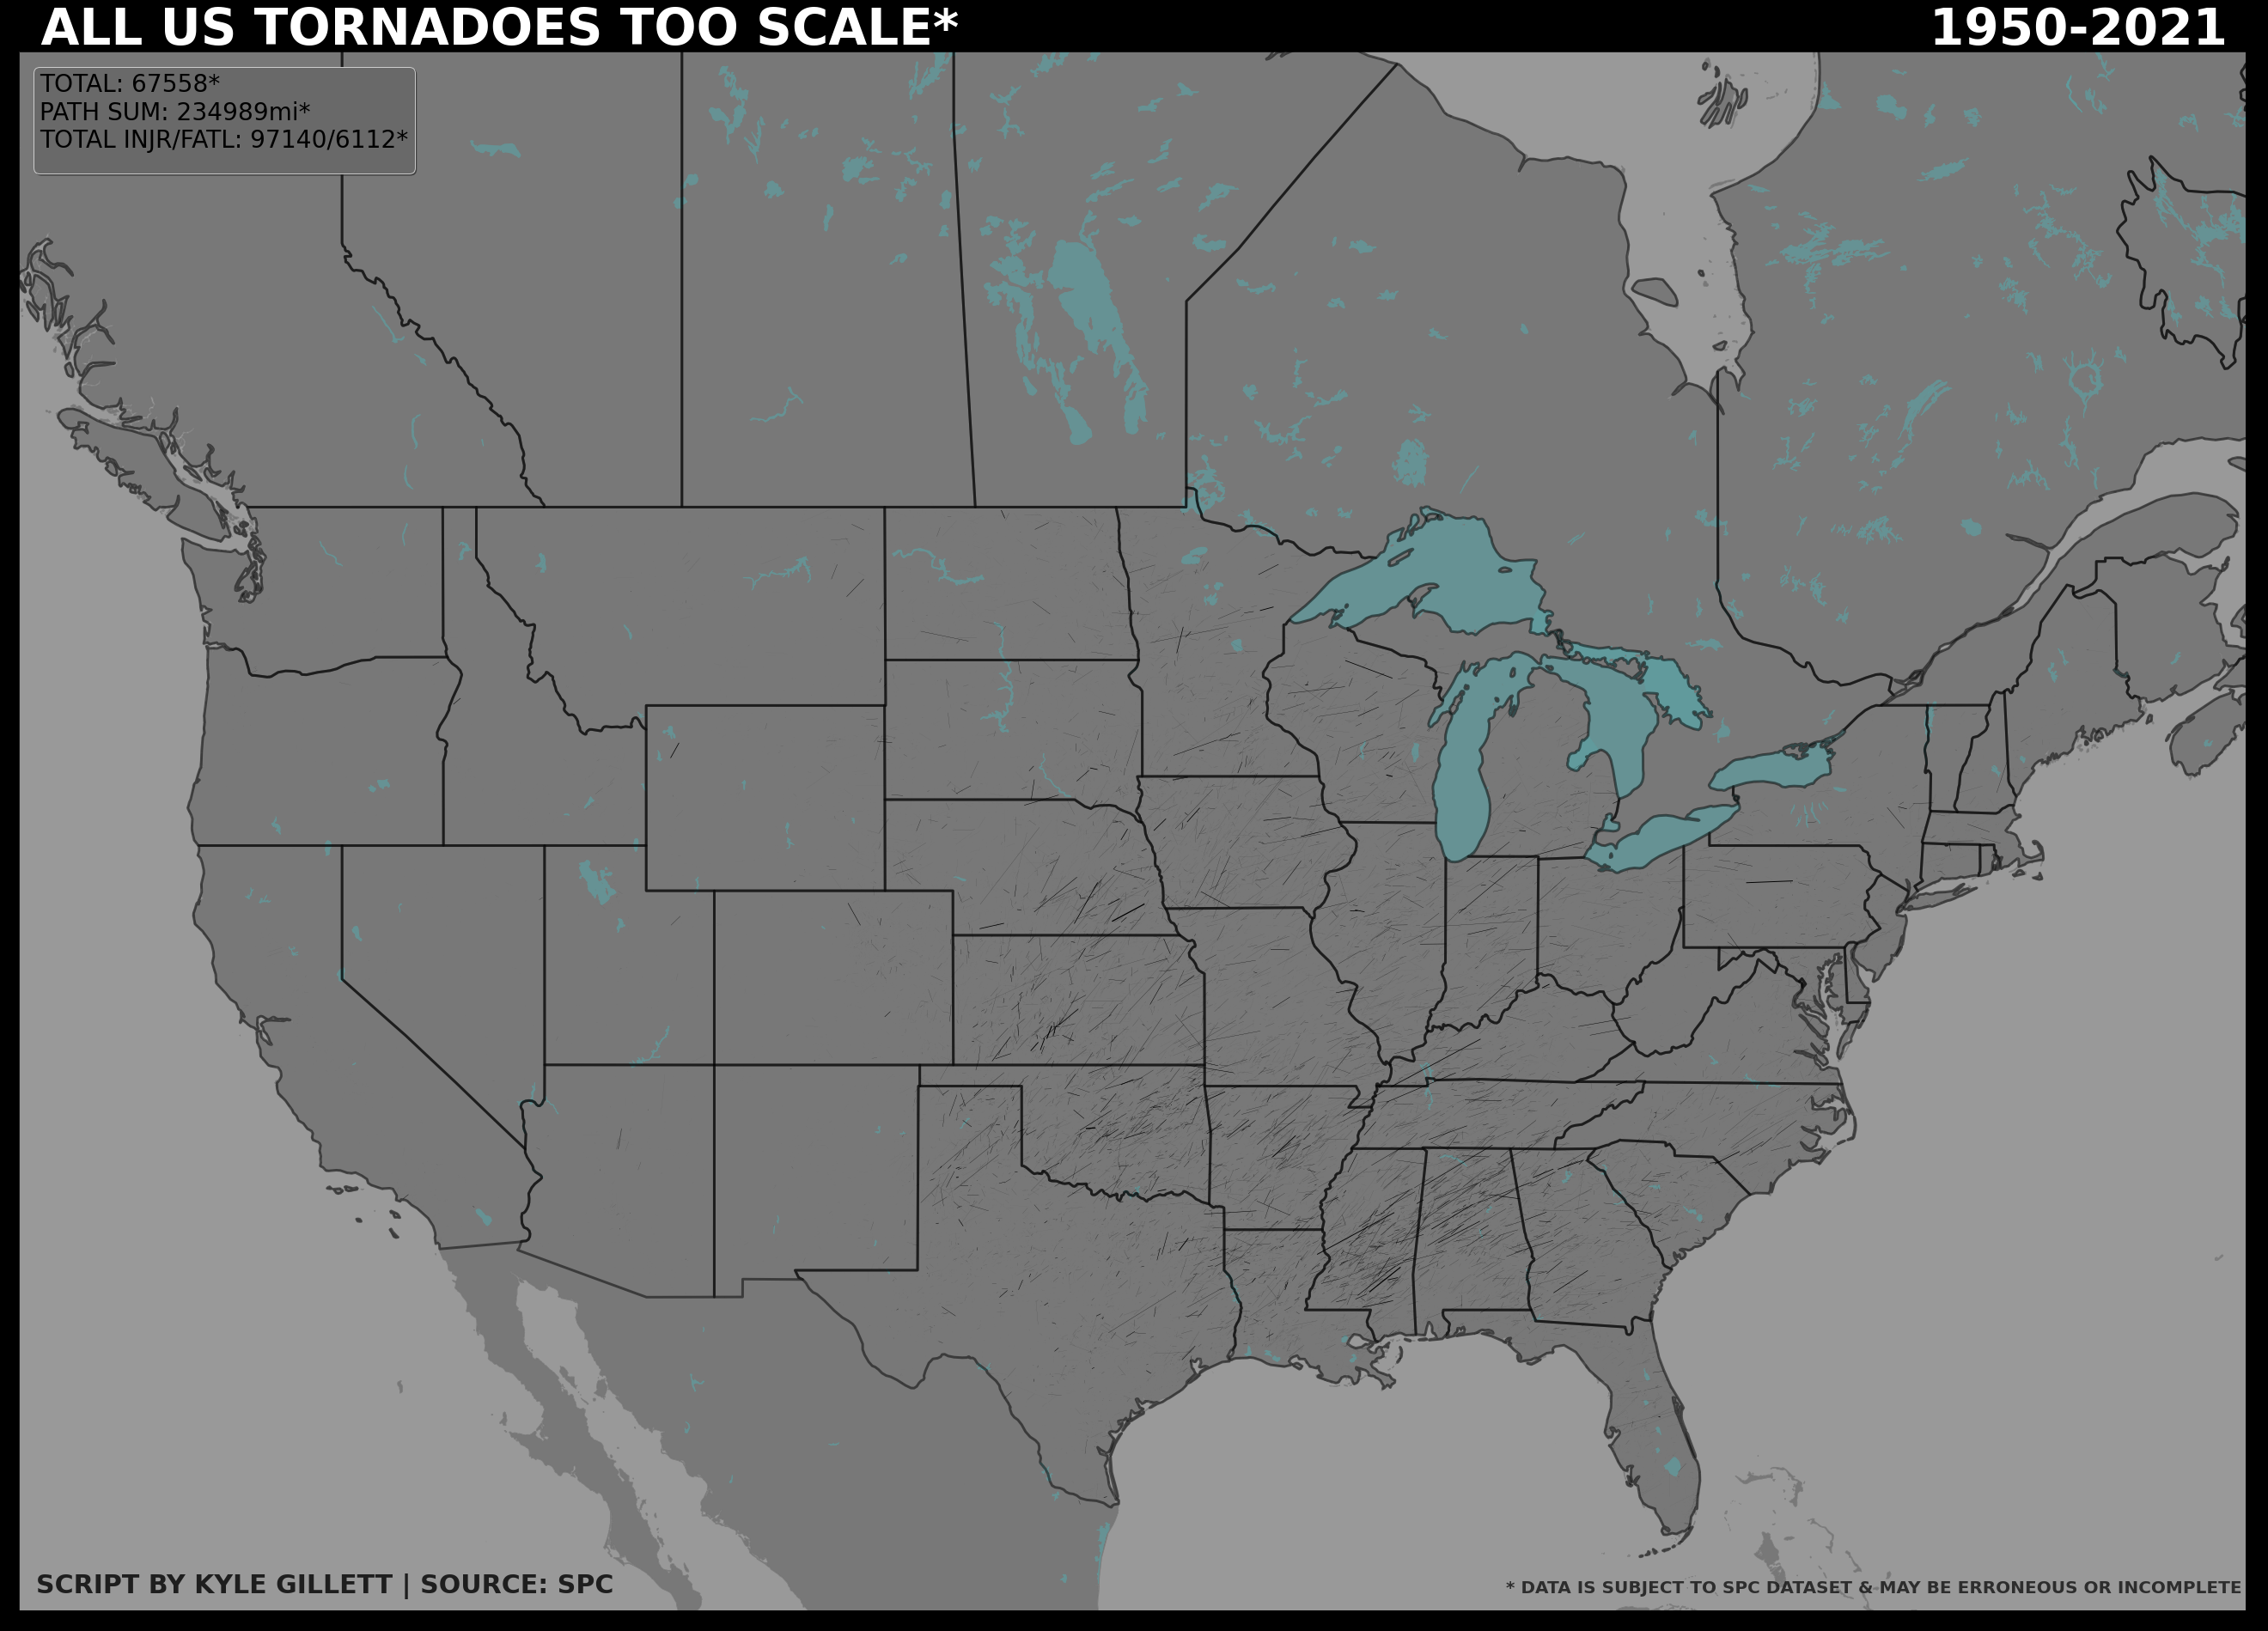

In [115]:
date1_string = '1950-2021'
tracks_df = pd.read_csv("https://www.spc.noaa.gov/wcm/data/1950-2021_actual_tornadoes.csv") #CSV TOR DATA
track_data = tracks_df 

# CORRECT TRACK LAT/LON POINT ERRORS (some end lat/lons are = zero, or equal to the start lat/lon
# because the path is around or less than 1 mile, so to simplifiy plotting, end lat/lons are set = to start lat/lons 
# plus 0.001 degrees of lat/lon)
track_data['elon'] = np.where(track_data['elon'] == 0, track_data['slon']+0.005, track_data['elon'])
track_data['elat'] = np.where(track_data['elat'] == 0, track_data['slat']+0.005, track_data['elat'])
track_data['elon'] = np.where(track_data['elon'] == track_data['slon'], track_data['slon']+0.005, track_data['elon'])
track_data['elat'] = np.where(track_data['elat'] == track_data['slat'], track_data['slat']+0.005, track_data['elat'])

# PARSE RATING MAGNITUDE INFORMATION
efu = track_data[track_data['fc']==1] 
ef0 = track_data[track_data['mag']==0] 
ef1 = track_data[track_data['mag']==1] 
ef2 = track_data[track_data['mag']==2] 
ef3 = track_data[track_data['mag']==3] 
ef4 = track_data[track_data['mag']==4] 
ef5 = track_data[track_data['mag']==5] 

# PARSE OUT SOME INFO ABOUT THE TORNADOES
total_path = int(track_data['len'].sum())
total_inj = track_data['inj'].sum()
total_fat = track_data['fat'].sum()

print(f'TORNADOES IN DATASET: {len(track_data)}')

city     = "Cottage Hill"
stateAbv = "KS"

# determine lat/lon of user specified city for map center
geolocator = Nominatim(user_agent="Your_Name") #do not change this line
loc = geolocator.geocode(city+','+ states[stateAbv])
center_lat = (np.round(loc.latitude,2))
center_lon = np.round(loc.longitude,2)
# YOU CAN SET MANUAL LAT/LON HERE IF YOU'D LIKE
#center_lat1 = 43.1 
#center_lon1 = -83.73
center_lat1 = center_lat
center_lon1 = center_lon
# CREATE SMALL GRIDDED AREA FOR MAP
north_lat = center_lat1 + .5
south_lat = center_lat1 - .5
west_lon = center_lon1 - .5
east_lon = center_lon1 + .5


# CREATE FIGURE PROPERTIES ############################################################################################################
plt.figure(facecolor='black', figsize=(12,7)) 
proj = ccrs.Mercator(central_longitude=center_lat1, min_latitude=south_lat-20, max_latitude=north_lat+20)
ax = plt.axes((0.877, -0.26, 3, 5), projection=proj) 
ax.set_box_aspect(0.7) 


# DETERMINE ZOOM LEVEL ############################################################################################################
ax.set_extent(([west_lon+16, east_lon-16, south_lat-16, north_lat+16]), ccrs.Geodetic())


# ADD MAP FEATURES ###################################################################################################################
ax.add_feature(cfeature.LAKES.with_scale('10m'), color='cadetblue', alpha=0.7, linewidth=0.5, zorder=2)
ax.add_feature(cfeature.OCEAN.with_scale('10m'), color='gray', alpha=0.8, zorder=2)
ax.add_feature(cfeature.LAND.with_scale('10m'), color='dimgray', alpha=0.9)
ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='black', alpha=0.5, linewidth=3, zorder=7)
#stamen_terrain = cimgt.Stamen('terrain-background')

# PLOT TORNADO TRACKS TO SCALE ###############################################################################################################
for i in efu.index:
    ax.plot([efu['slon'][i], efu['elon'][i]], [efu['slat'][i], efu['elat'][i]], color='black', linewidth=(efu['wid'][i])/3456, transform=ccrs.PlateCarree(), zorder=6)
for i in ef0.index:
    ax.plot([ef0['slon'][i], ef0['elon'][i]], [ef0['slat'][i], ef0['elat'][i]], color='black', linewidth=(ef0['wid'][i])/3456, transform=ccrs.PlateCarree(), zorder=6)
for i in ef1.index:
    ax.plot([ef1['slon'][i], ef1['elon'][i]], [ef1['slat'][i], ef1['elat'][i]], color='black', linewidth=(ef1['wid'][i])/3456, transform=ccrs.PlateCarree(), zorder=6)
for i in ef2.index:
    ax.plot([ef2['slon'][i], ef2['elon'][i]], [ef2['slat'][i], ef2['elat'][i]], color='black', linewidth=(ef2['wid'][i])/3456, transform=ccrs.PlateCarree(), zorder=6)
for i in ef3.index:
    ax.plot([ef3['slon'][i], ef3['elon'][i]], [ef3['slat'][i], ef3['elat'][i]], color='black', linewidth=(ef3['wid'][i])/3456, transform=ccrs.PlateCarree(), zorder=6)
for i in ef4.index:
    ax.plot([ef4['slon'][i], ef4['elon'][i]], [ef4['slat'][i], ef4['elat'][i]], color='black', linewidth=(ef4['wid'][i])/3456, transform=ccrs.PlateCarree(), zorder=6)
for i in ef5.index:
    ax.plot([ef5['slon'][i], ef5['elon'][i]], [ef5['slat'][i], ef5['elat'][i]], color='black', linewidth=(ef5['wid'][i])/3456, transform=ccrs.PlateCarree(), zorder=6)   

# # PLOT COLORED TORNADO TRACKS ###############################################################################################################
# ax.plot([efu['slon'], efu['elon']], [efu['slat'], efu['elat']], color='lightcyan', linewidth=6, transform=ccrs.PlateCarree(), path_effects=[pe.Stroke(linewidth=9, foreground='black'), pe.Normal()], zorder=6)
# ax.plot([ef0['slon'], ef0['elon']], [ef0['slat'], ef0['elat']], color='lightblue', linewidth=6, transform=ccrs.PlateCarree(), path_effects=[pe.Stroke(linewidth=9, foreground='black'), pe.Normal()], zorder=6)
# ax.plot([ef1['slon'], ef1['elon']], [ef1['slat'], ef1['elat']], color='yellowgreen', linewidth=6, transform=ccrs.PlateCarree(), path_effects=[pe.Stroke(linewidth=9, foreground='black'), pe.Normal()], zorder=6)
# ax.plot([ef2['slon'], ef2['elon']], [ef2['slat'], ef2['elat']], color='gold', linewidth=7, transform=ccrs.PlateCarree(), path_effects=[pe.Stroke(linewidth=10, foreground='black'), pe.Normal()], zorder=6)
# ax.plot([ef3['slon'], ef3['elon']], [ef3['slat'], ef3['elat']], color='orangered', linewidth=8, transform=ccrs.PlateCarree(), path_effects=[pe.Stroke(linewidth=11, foreground='black'), pe.Normal()], zorder=6)
# ax.plot([ef4['slon'], ef4['elon']], [ef4['slat'], ef4['elat']], color='firebrick', linewidth=11, transform=ccrs.PlateCarree(), path_effects=[pe.Stroke(linewidth=14, foreground='black'), pe.Normal()], zorder=6)
# ax.plot([ef5['slon'], ef5['elon']], [ef5['slat'], ef5['elat']], color='purple', linewidth=14, transform=ccrs.PlateCarree(), path_effects=[pe.Stroke(linewidth=17, foreground='black'), pe.Normal()], zorder=6)

# #dummy data to make the legend clean
# ax.plot(-100, 100, color='purple', linewidth=14, transform=ccrs.PlateCarree(), path_effects=[pe.Stroke(linewidth=18, foreground='black'), pe.Normal()], label = f'(E)F5: {len(ef5)}')
# ax.plot(-100, 100, color='firebrick', linewidth=14, transform=ccrs.PlateCarree(), path_effects=[pe.Stroke(linewidth=18, foreground='black'), pe.Normal()], label = f'(E)F4: {len(ef4)}')
# ax.plot(-100, 100, color='orangered', linewidth=14, transform=ccrs.PlateCarree(), path_effects=[pe.Stroke(linewidth=18, foreground='black'), pe.Normal()], label = f'(E)F3: {len(ef3)}')
# ax.plot(-100, 100, color='gold', linewidth=14, transform=ccrs.PlateCarree(), path_effects=[pe.Stroke(linewidth=18, foreground='black'), pe.Normal()], label = f'(E)F2: {len(ef2)}')
# ax.plot(-100, 100, color='yellowgreen', linewidth=14, transform=ccrs.PlateCarree(), path_effects=[pe.Stroke(linewidth=18, foreground='black'), pe.Normal()], label = f'(E)F1: {len(ef1)}')
# ax.plot(-100, 100, color='lightblue', linewidth=14, transform=ccrs.PlateCarree(), path_effects=[pe.Stroke(linewidth=18, foreground='black'), pe.Normal()], label = f'(E)F0: {len(ef0)}')
# ax.plot(-100, 100, color='lightcyan', linewidth=14, transform=ccrs.PlateCarree(), path_effects=[pe.Stroke(linewidth=18, foreground='black'), pe.Normal()], label = f'(E)FU: {len(efu)}')

# # # PLOT BLACK TORNADO TRACKS ###############################################################################################################
# ax.plot([efu['slon'], efu['elon']], [efu['slat'], efu['elat']], color='lightcyan', linewidth=1, transform=ccrs.PlateCarree(),zorder=6)
# ax.plot([ef0['slon'], ef0['elon']], [ef0['slat'], ef0['elat']], color='lightblue', linewidth=1, transform=ccrs.PlateCarree(),zorder=6)
# ax.plot([ef1['slon'], ef1['elon']], [ef1['slat'], ef1['elat']], color='yellowgreen', linewidth=1, transform=ccrs.PlateCarree(),zorder=6)
# ax.plot([ef2['slon'], ef2['elon']], [ef2['slat'], ef2['elat']], color='gold', linewidth=1, transform=ccrs.PlateCarree(), zorder=6)
# ax.plot([ef3['slon'], ef3['elon']], [ef3['slat'], ef3['elat']], color='orangered', linewidth=3, transform=ccrs.PlateCarree(), zorder=6)
# ax.plot([ef4['slon'], ef4['elon']], [ef4['slat'], ef4['elat']], color='firebrick', linewidth=3, transform=ccrs.PlateCarree(), zorder=6)
# ax.plot([ef5['slon'], ef5['elon']], [ef5['slat'], ef5['elat']], color='purple', linewidth=3, transform=ccrs.PlateCarree(), zorder=6)


# PLOT TITLES AND DATA ################################################################################################################
# create a custom title or leave it to automation
#title_string = 'April 27th, 2011 Super Outbreak Tornado Tracks'
plt.figtext(0.86, 4.057, f'  ALL US TORNADOES TOO SCALE*', weight='bold', fontsize=58, ha='left', color='white')
plt.figtext(3.90, 4.057, f'{date1_string}  ', weight='bold', fontsize=58, ha='right', color='white')
plt.figtext(0.90, 0.48, f'SCRIPT BY KYLE GILLETT | SOURCE: SPC', weight='bold', color='black', fontsize=30, ha='left', alpha=0.8)
plt.figtext(3.88, 0.48, f'* DATA IS SUBJECT TO SPC DATASET & MAY BE ERRONEOUS OR INCOMPLETE ', weight='bold', color='black', fontsize=20, ha='right', alpha=0.7)
plt.figtext(0.90, 0.41, f' ')
ax.legend(loc='upper left', fontsize=35, facecolor='dimgray', markerscale=10, framealpha=1, labelcolor='linecolor', shadow=True, borderpad=0.2, title=f'TOTAL: {len(track_data)}*\nPATH SUM: {total_path}mi*\nTOTAL INJR/FATL: {total_inj}/{total_fat}*', title_fontsize=28).set_zorder(10)

#print(f'YOU ARE PLOTTING: A "{plotType}" PLOT \nPLOT DATE: "{date1_string}"\nCENTER LOCATION: "{city}, {stateAbv}"\nZOOM LEVEL: "{zoomLevel}"\nBACKGROUND STYLE: "{background}"')
